In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import ast
from transformers import DistilBertTokenizerFast, TFDistilBertModel

## Amazon Dataset Preparation

In [2]:
filenames  = []
categories = []

In [3]:
for cat in range(42):
    cat_name = '{:02d}'.format(cat)
    for filename in glob.glob("shopee-product-detection-dataset/train/{}/*.jpg".format(cat_name)):
        filenames.append(filename[42:])
        categories.append(cat)

In [4]:
df = pd.DataFrame({'filename':filenames, 'category':categories})
df.head()

,filename,category
0,00238db878fdf555edc96e32146050ee.jpg,0
1,002e61675eefed2d07e28d07d6e9abc8.jpg,0
2,0043d124c7e628fd077d34838f41e48c.jpg,0
3,0044a144f988893a4222eedff4eebc39.jpg,0
4,00939a7597c499cd217e0fb753259754.jpg,0


In [5]:
len(df)

105059

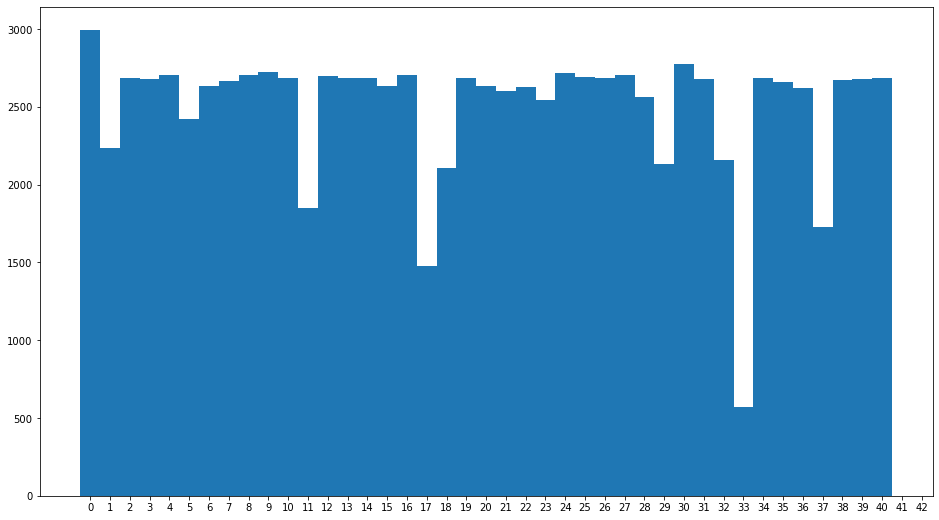

In [6]:
plt.figure(figsize=(16, 9))
plt.hist(df['category'], bins=np.arange(42)-0.5)
plt.xticks(np.arange(43));

In [7]:
df.to_csv('shopee-product-detection-dataset/train.csv', index=False)

## Add Extra Features

In [33]:
df_extra = pd.read_csv("extra-features/train_ocr.csv")
df_extra['filename'] = df_extra['path'].apply(lambda x : x[68:])
df_extra['annot']    = df_extra['annot'].apply(lambda x : ast.literal_eval(x))
df_extra.head()

,path,annot,filename
0,/kaggle/input/shopee-product-detection-student...,[],4b22788e5af1ae4544c5c7595908055e.jpg
1,/kaggle/input/shopee-product-detection-student...,"[NA321705000, Nu, Amoorea, BPOM, DEP, bar, No,...",4916aeccd05286da5326dbcce12a3067.jpg
2,/kaggle/input/shopee-product-detection-student...,[],541a9abc03b1f119989d8c202214e36e.jpg
3,/kaggle/input/shopee-product-detection-student...,"[PEAMY, REAINY, SCRUB, OFFEE, OFFER, MISSK, RE...",e03419b0ec4262d62c0178c1fa88205c.jpg
4,/kaggle/input/shopee-product-detection-student...,"[trulum, wajah, Day, alami, dari, kali, kulit,...",535beba6ad2034552a4d9188dae465cd.jpg


In [46]:
df_ = df.merge(df_extra, how="left", on="filename")
for row in df_.loc[df_.annot.isnull(), 'annot'].index:
    df_.at[row, 'annot'] = []
df_.head()

,filename,category,path,annot
0,00238db878fdf555edc96e32146050ee.jpg,0,/kaggle/input/shopee-product-detection-student...,"[Papier, Dathle]"
1,002e61675eefed2d07e28d07d6e9abc8.jpg,0,/kaggle/input/shopee-product-detection-student...,[A]
2,0043d124c7e628fd077d34838f41e48c.jpg,0,/kaggle/input/shopee-product-detection-student...,[]
3,0044a144f988893a4222eedff4eebc39.jpg,0,/kaggle/input/shopee-product-detection-student...,"[Hitam, Salur, Teby]"
4,00939a7597c499cd217e0fb753259754.jpg,0,/kaggle/input/shopee-product-detection-student...,[]


In [49]:
df_['annot_len'] = df_['annot'].apply(lambda x : len(x))
df_.head()

,filename,category,path,annot,annot_len
0,00238db878fdf555edc96e32146050ee.jpg,0,/kaggle/input/shopee-product-detection-student...,"[Papier, Dathle]",2
1,002e61675eefed2d07e28d07d6e9abc8.jpg,0,/kaggle/input/shopee-product-detection-student...,[A],1
2,0043d124c7e628fd077d34838f41e48c.jpg,0,/kaggle/input/shopee-product-detection-student...,[],0
3,0044a144f988893a4222eedff4eebc39.jpg,0,/kaggle/input/shopee-product-detection-student...,"[Hitam, Salur, Teby]",3
4,00939a7597c499cd217e0fb753259754.jpg,0,/kaggle/input/shopee-product-detection-student...,[],0


In [51]:
sum(df_['annot_len'] != 0), len(df_)

(73085, 105063)

(array([1630.,  600.,  951., 1005.,  753., 1333., 1337.,  776., 1122.,
        1015.,  799.,  635.,  405.,  427.,  621.,  214., 1094.,  623.,
         579.,  190., 1287.,  422.,  848., 1168.,  318.,  802.,  698.,
         411.,  875.,  703.,  856.,  343.,  451.,   13.,  271.,  272.,
         824.,  936.,  982., 1321.,  852., 1216.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5,
        32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5]),
 <a list of 42 Patch objects>)

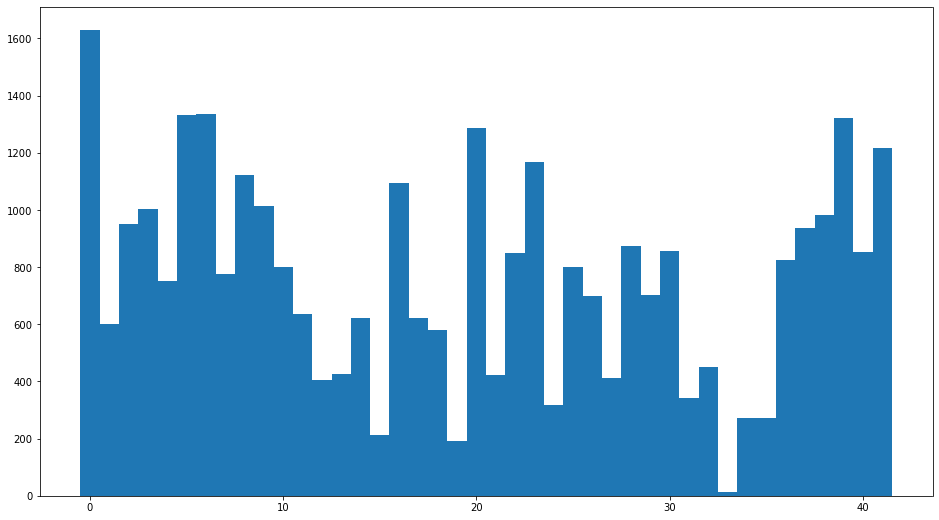

In [54]:
plt.figure(figsize=(16, 9))
plt.hist(df_[df_['annot_len'] == 0]['category'], bins=np.arange(43)-0.5)

(-1.0, 40.0)

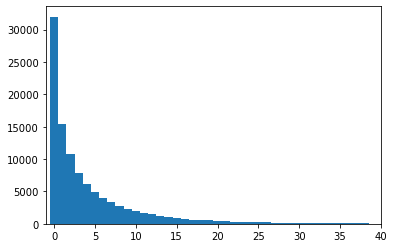

In [58]:
plt.hist(df_['annot_len'], bins=np.arange(40)-0.5)
plt.xlim((-1, 40))

## Prepare Gcloud CSV

In [55]:
filenames = []
bucket_dir = "shopee-product-detection-bruh"

from google.cloud import storage
storage_client = storage.Client()
blobs = storage_client.list_blobs(bucket_dir, prefix="test/")
for blob in blobs:
    filenames.append("gs://" + bucket_dir + "/" + blob.name)

c:\users\franz cesista\appdata\local\programs\python\python36\lib\site-packages\google\auth\_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [57]:
df = pd.DataFrame(filenames[1:])
df.head()

,0
0,gs://shopee-product-detection-bruh/test/0004b0...
1,gs://shopee-product-detection-bruh/test/0004d3...
2,gs://shopee-product-detection-bruh/test/000d4a...
3,gs://shopee-product-detection-bruh/test/0012f1...
4,gs://shopee-product-detection-bruh/test/001583...


In [58]:
df.to_csv("storage_test.csv", index=False, header=False)